In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# load raw financial data
# hourly resolution
gamestop_data = pd.read_csv('../foobar/data/raw/stock_candle_60_2020-03-01_2021-03-01.csv')

gamestop_data = gamestop_data.sort_values(by=['timestamp'], axis=0)
gamestop_data['datetime'] = pd.to_datetime(gamestop_data['timestamp'], unit='s')
gamestop_data = gamestop_data.set_index('datetime')

# resmaple the data hourly and pad the gaps with the previous record
gamestop_data = gamestop_data.resample('H', label='right').pad()
print(gamestop_data.shape)

train_data = gamestop_data[gamestop_data.index.year == 2020]
short_squeeze_data = gamestop_data[gamestop_data.index.year == 2021]
print(train_data.shape)
print(short_squeeze_data.shape)

(7692, 8)
(6395, 8)
(1297, 8)


In [5]:
# loading wide table
df_wide = pd.read_csv('../microservices/dash_app/wide.csv')
df_wide['datetime'] = pd.to_datetime(df_wide['hour'], format='%Y-%m-%d %H:%M:%S')
df_wide = df_wide.set_index('datetime')

train_df_wide = df_wide[df_wide.index.year == 2020]
test_df_wide = df_wide[df_wide.index.year == 2021]

## Data Preprocessing

In [6]:
# create train and test dataset
# sorted based on timestamp 

# extract timestamps for visualization
train_datetime_list = list(train_data.index)
target_datetime_list = list(short_squeeze_data.index)
gamestop_datetime_list = list(gamestop_data.index)

# reordering the columns: put the prediction column to the last column
cols = ['open_price', 'high-price', 'low-price', 'volume','close_price']

df_train = train_data[cols]
df_target = short_squeeze_data[cols]
df_gamestop = gamestop_data[cols]

# check the df column types to ensure they have correct types
print(df_train.dtypes)
cols

open_price     float64
high-price     float64
low-price      float64
volume           int64
close_price    float64
dtype: object


['open_price', 'high-price', 'low-price', 'volume', 'close_price']

In [7]:
train_datetime_list = list(train_df_wide.index)
test_datetime_list = list(test_df_wide.index)

feature_set_narrow = ["openprice", "highprice", "lowprice", "volume", "closeprice"]

feature_set_wide = [
    "avg_all_post_pos",
    "avg_all_post_neg",
    "avg_all_post_neu",
    "cnt_all_user",
    "cnt_all_tag",
    "cnt_all_post",
    "cnt_all_comments",
    "avg_gme_post_pos",
    "avg_gme_post_neg",
    "avg_gme_post_neu",
    "cnt_gme_user",
    "cnt_gme_tag",
    "cnt_gme_post",
    "cnt_gme_comments",
    "volume",
    "openprice",
    "highprice",
    "lowprice",
    "closeprice"
]




<AxesSubplot:xlabel='datetime'>

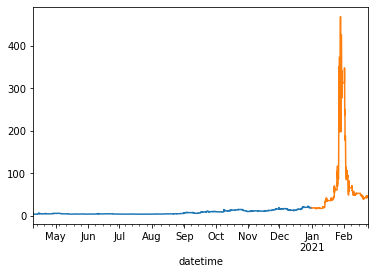

In [8]:
df_train['close_price'].plot()
df_target['close_price'].plot()

In [9]:
# finding missing values
df_train.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

In [10]:
df_target.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

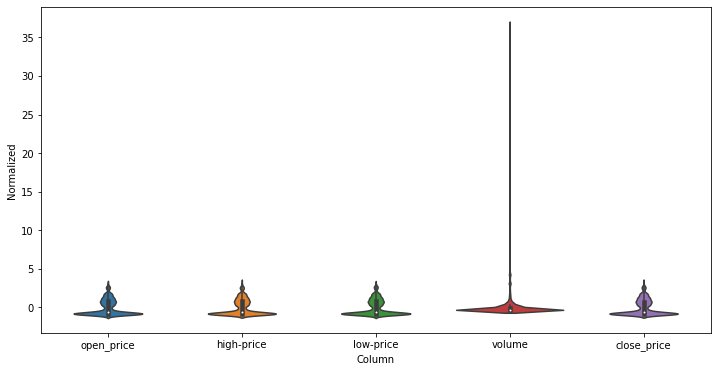

In [11]:
# Visualize the ditribution of the features in the train dataset
df_std = (df_train - df_train.mean()) / df_train.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


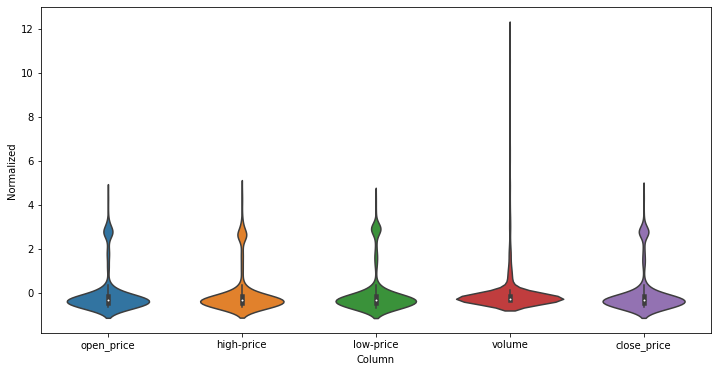

In [12]:
df_std = (df_target - df_target.mean()) / df_target.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [66]:
def scale(df, feature_set, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
#         scaler = MinMaxScaler()
        scaled_arr = scaler.fit_transform(df[feature_set])
    else:
        scaled_arr = scaler.fit_transform(df[feature_set])
    return scaled_arr, scaler

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [67]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window+pred_horizon-1:i+train_window+pred_horizon, -1]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    dataset_seq = (x_tensor, y_tensor)
    return dataset_seq, num_features

def create_batch_set(dataset_seq, batch_size = 100):
    x_tensor, y_tensor = dataset_seq
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    return tensor_dataloader

In [68]:
# various feature sets for model selection
feature_set1 = ['open_price', 'high-price', 'low-price', 'volume', 'close_price']
feature_set2 = ['open_price', 'high-price', 'low-price', 'close_price']
feature_set3 = ['open_price', 'volume', 'close_price']
feature_set4 = ['volume', 'close_price']
feature_sets = [feature_set1, feature_set1, feature_set3, feature_set4]

# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)

train_window_list = np.array([3, 5, 10, 24, 24*2, 24*5, 24*7])
prediction_horizon_list = np.array([1, 2, 3, 5, 24*1, 24*2, 24*3])

# choose these set for testing 
feature_set = feature_sets[0]
train_window = train_window_list[2]
prediction_horizon = prediction_horizon_list[1]
print(train_window)
print(prediction_horizon)

train_set, train_scaler = scale(df_train, feature_set)
target_set, _ = scale(df_target, feature_set, train_scaler)
train_set , val_set = split(train_set, 0.8)

gamestop_set, _ = scale(df_gamestop, feature_set, train_scaler)

train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, train_window, prediction_horizon)

x_train, _ =train_seq
x_val, _ = val_seq
train_batch_size = int(len(x_train)*0.5)
val_batch_size = int(len(x_val)*1)

train_batches = create_batch_set(train_seq, batch_size=100)
val_batches = create_batch_set(val_seq, batch_size=2)

target_seq, _ = generate_window(target_set, train_window, prediction_horizon)
gamestop_seq, _ = generate_window(gamestop_set, train_window, prediction_horizon)

datetime_target = target_datetime_list[train_window+prediction_horizon:]
datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]


10
2


## Creating LSTM Network

In [69]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden_state = None
        self.cell_state = None
        self.hidden = (self.hidden_state, self.cell_state)

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        outputs = self.linear(lstm_out.reshape(x.size(0),-1))
        return outputs


## Traning LSTM model

In [70]:
def train_model(model, device, train_batches, val_batches=None, num_epochs=50):

    learning_rate = 1e-3
    train_losses = []
    val_losses = []
    best_loss = np.Inf
    val_loss = None
    

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        batch_losses = []
        for batch_ndx, train_batch in enumerate(train_batches):
            model.train()
            x_train, y_train = train_batch
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_loss = loss.item()
            batch_losses.append(batch_loss)
            
        if val_batches is not None:
            model.eval()
            with torch.no_grad():
                val_batch_losses = []
                for _, val_batch in enumerate(val_batches):
                    x_val, y_val = val_batch
                    batch_size = x_val.size(0)
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    model.init_hidden(batch_size, device)
                    pred = model(x_val)
                    loss = criterion(pred, y_val)
                    val_loss = loss.item()
                    val_batch_losses.append(val_loss)
                    if val_loss < best_loss:
                        best_loss = val_loss
        
        val_losses_mean = np.mean(val_batch_losses)
        batch_losses_mean = np.mean(batch_losses)
        print(f"Epoch {epoch}: train loss {batch_losses_mean}, val loss {val_losses_mean}")
        val_losses.append(val_losses_mean)
        train_losses.append(batch_losses_mean)
        
        
    return model.eval(), train_losses, val_losses

In [71]:
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
# torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, train_losses, val_losses = train_model(model, device, train_batches, val_batches, num_epochs=50)

cuda
Epoch 0: train loss 0.23026861065031531, val loss 0.3849351381470247
Epoch 1: train loss 0.27790810494983675, val loss 0.818883686012086
Epoch 2: train loss 0.052898843753120255, val loss 0.03381746663164911
Epoch 3: train loss 0.023511745744774368, val loss 0.20778942862540273
Epoch 4: train loss 0.02714608352443275, val loss 0.05541597168735145
Epoch 5: train loss 0.012968618362300241, val loss 0.26506717267150776
Epoch 6: train loss 0.025243741984013468, val loss 0.05644480747235375
Epoch 7: train loss 0.016627700350139864, val loss 0.31610149893563017
Epoch 8: train loss 0.031556616991180744, val loss 0.054720973822514174
Epoch 9: train loss 0.019983250502823815, val loss 0.3682957435811191
Epoch 10: train loss 0.03845204834774799, val loss 0.051215305726563194
Epoch 11: train loss 0.022244430492999248, val loss 0.377320606092561
Epoch 12: train loss 0.03920103679634989, val loss 0.05619993428178764
Epoch 13: train loss 0.02055756390361169, val loss 0.3704256337952774
Epoch 14

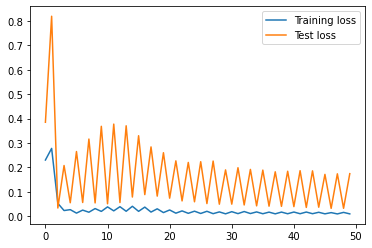

In [72]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Test loss")
plt.legend()

## Predictions

In [64]:
observed, predicted, losses = [], [], []
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)
print(device)

X_test, y_test = target_seq
test_set_size = X_test.size(0)

# model.init_hidden(X_test.size(0), device)
# y_pred = model(X_test)

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        predicted.append(y_pred.item())
        losses.append(loss.item())
        
observed = y_test.cpu().numpy().flatten()
# predictions = y_pred.cpu().numpy().flatten()
predictions = np.array(predicted).flatten()

cpu


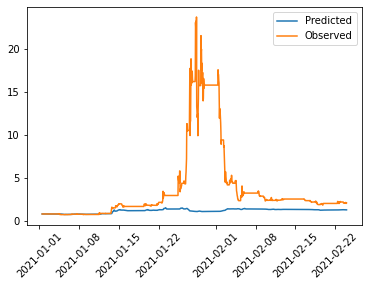

In [65]:

plt.plot(datetime_target,predictions, label="Predicted")
plt.plot(datetime_target, observed, label="Observed")
plt.xticks(rotation=45)
plt.legend()

0.25710924428913007

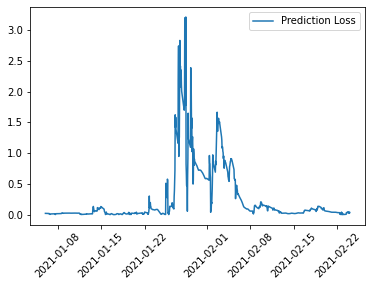

In [28]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)

In [71]:
# saving prediciton result as csv file for the entire dataset
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)

X_test, y_test = gamestop_seq
test_set_size = X_test.size(0)

res = df_gamestop.copy()
res['predictions'] = np.nan
res['loss'] = np.nan

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        res.at[datetime_gamestop[i], 'predictions'] = y_pred.cpu().numpy().flatten()
        res.at[datetime_gamestop[i], 'loss'] = loss.item()
        predictions.append(y_pred.cpu().numpy().flatten())
        losses.append(loss.item())
        
        
truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

In [ ]:
out_csv = res.drop('loss', axis=1)
out_csv.to_csv('../foobar/data/processed/gme_predictions_m1.csv')
res

In [ ]:
plt.plot(datetime_gamestop,predictions, label="Predictions")
plt.plot(datetime_gamestop, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [ ]:
print('Saving...')
state = {
    'model': model.state_dict(),
    'scaler': train_scaler,
    'feature_set': feature_set,
    'history': history,
    'pred_horizon': prediction_horizon,
    'train_window': train_window
}

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, f'./checkpoint/m1.pth')

In [ ]:
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_index = 0
for train_window in train_window_list:
    for prediction_horizon in prediction_horizon_list:
#         for feature_set in feature_sets:
        if prediction_horizon > train_window:
            break
            
#         train_set, train_scaler = scale(df_train, feature_set)
#         target_set, _ = scale(df_target, feature_set, train_scaler)
#         train_set , val_set = split(train_set, 0.8)
        
        
#         train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
#         val_seq, _ = generate_window(val_set, train_window, prediction_horizon)

#         train_batches = create_batch_set(train_seq)
#         val_batches = create_batch_set(val_seq)

#         target_seq, _ = generate_window(target_set, train_window, prediction_horizon)
#         gamestop_seq, _ = generate_window(gamestop_set, train_window, prediction_horizon)

#         datetime_target = target_datetime_list[train_window+prediction_horizon:]
#         datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]

        
#         train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
#         val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
#         target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

        datetime_target = target_datetime_list[train_window+prediction_horizon:]
        
        model = LSTM(input_size=num_features, seq_length=train_window)
        model = model.to(device)

        model, history, _ = train_model(model, device, train_seq, val_seq, num_epochs=100)
        visualization(history)
        model_index += 1

        print('Saving...')
        state = {
            'model': model.state_dict(),
            'scaler': train_scaler,
            'feature_set': feature_set,
            'history': history,
            'pred_horizon': prediction_horizon,
            'train_window': train_window
        }

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/train_m{model_index}.pth')

            
        plt.plot(history['train'], label="Training loss")
        plt.plot(history['val'], label="Test loss")
        plt.legend()
        
        truth, predictions, losses = [], [], []

        criterion = nn.L1Loss(reduction='sum').to(device)
        model.to(device)

        X_test, y_test = target_seq
        test_set_size = X_test.size(0)

        with torch.no_grad():
            model.eval()
            for i in range(test_set_size):
                x_i = X_test[i:i+1]
                y_i = y_test[i:i+1]
                x_i.to(device)
                y_i.to(device)
                model.init_hidden(x_i.size(0), device)
                y_pred = model(x_i)
                predictions.append(y_pred.cpu().numpy().flatten())
                loss = criterion(y_pred, y_i)
                losses.append(loss.item())

        truth = y_test.cpu().numpy().flatten()
        predictions = np.array(predictions).flatten()
        
        plt.plot(datetime_target,predictions, label="Predictions")
        plt.plot(datetime_target, truth, label="Truth")
        plt.xticks(rotation=45)
        plt.legend()